# Behavior Cloning

In [36]:
run_local = False

name = 'nvmodel2-RGB'

retrain = True

data_path = 'data' 
project = 'P-995-CarND-Behavior-Cloning'

BS = 128*2 
n_epochs = 0  

size = 64
dim_new = (size, size)
input_shape = (size, size, 3)

angle_adjustment = 0.2

SEED = 100
SPLIT = 0.2

import os 
import pathlib

if run_local:
    home = str(pathlib.Path.home())
    home = os.path.join(home, 'n-datasets', project)
else:
    home = '.'
    
model_name = os.path.join(home, name+'.h5')
log_name = os.path.join('results', name+'.csv')

print(model_name)
print(log_name)

./nvmodel2-RGB.h5
results/nvmodel2-RGB.csv


# Imports

In [2]:
%matplotlib inline 

import glob 
import os 
import csv 
import cv2
import gc 
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
from collections import Counter

import os
import random
import numpy as np

from PIL import Image

import numpy as np

import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle  

import scipy.misc 
from scipy.ndimage import rotate
from scipy import ndimage, misc

import tensorflow as tf 
import keras 

from keras.models import Sequential
from keras.layers import Convolution2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, Lambda
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.optimizers import Adam


from keras import backend as K
#K.clear_session()
#gc.collect()


/Users/naneja/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/naneja/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/naneja/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/naneja/.conda/envs/py35/lib/python3.5/site-packages

In [3]:
#!conda install -c conda-forge openblas=0.2.19 --yes 

In [4]:
#os.environ['PYTHONHASHSEED']=str(SEED)
#np.random.seed(SEED)
#random.seed(SEED)


data = sorted(glob.glob(os.path.join(home, data_path, 'IMG', '*.jpg')))
print(len(data))


log = os.path.join(home, data_path, 'driving_log.csv')

24108


In [37]:
df = pd.read_csv(log)
df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [6]:
def trim_image(image, top=0.30, bottom=0.1):
    width, height = image.shape[1], image.shape[0]
    
    upper = int(height * top)
    lower = height - int(height * bottom)
        
    image = image[upper: lower, :]
    
    return image


def resize_image(image, dim=dim_new):
    #image = scipy.misc.imresize(image, dim)
    image = np.array(Image.fromarray(image).resize(dim))
    #image = scipy.misc.imresize(image, dim)
    return image

 
def flip_image(image):
    image = np.fliplr(image)
    
    return image


def bright_image(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    # randomly generate the brightness reduction factor
    # Add a constant so that it prevents the image from being completely dark
    random_bright = .25 + np.random.uniform()

    # Apply the brightness reduction to the V channel
    image1[:,:,2] = image1[:,:,2]*random_bright

    # convert to RBG again
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def rotate_image(image, angle):
    image = ndimage.rotate(image, angle, reshape=False)
    return image 

In [7]:
images_center_camera = df.center.tolist()
images_left_camera = df.left.tolist()
images_right_camera = df.right.tolist()

angles = df.steering.tolist()

assert len(images_center_camera) == len(images_left_camera) == len(images_right_camera) == len(angles)

In [8]:
# Take Valid Set from Center Camera Images
images_center_camera, angles = shuffle(images_center_camera, angles)

images_train, images_valid, angles_train, angles_valid = train_test_split(images_center_camera, angles, test_size=SPLIT, random_state=SEED)

In [9]:
d_straight, d_left, d_right = [], [], []
a_straight, a_left, a_right = [], [], []

for image, angle in zip(images_train, angles_train):
    
    if -0.15 <= angle and angle <= 0.15: # Straight
        d_straight.append(image)
        a_straight.append(angle)

    if angle < -0.15: # right -> left
        d_left.append(image)
        a_left.append(angle)
        
    if angle > 0.15: # left -> right
        d_right.append(image)
        a_right.append(angle)
print(df.shape[0], len(images_train), len(d_straight), len(d_left), len(d_right))
assert len(images_train) == len(d_straight) + len(d_left) + len(d_right)

8036 6428 5231 477 720


In [10]:
# Balancing Images from left and right camera images
n_left = df.shape[0] - len(d_left)
n_right = df.shape[0] - len(d_right)
print(n_left, n_right)

7559 7316


In [11]:
idxs_left = random.sample(range(df.shape[0]), n_left)
idxs_right = random.sample(range(df.shape[0]), n_right)

for i in range(5):
    idxs_left += random.sample(range(df.shape[0]), n_left)
    idxs_right += random.sample(range(df.shape[0]), n_right)

print(len(idxs_left), len(idxs_right))

45354 43896


In [12]:
# Center, Left, Right
for idx in idxs_left:
    ang = df.iloc[idx, 3]
    if ang < -0.15:
        d_left.append(df.iloc[idx, 2])
        a_left.append(ang - angle_adjustment)
print(len(d_left), len(a_left))

3820 3820


In [13]:
# Center, Left, Right
for idx in idxs_right:
    ang = df.iloc[idx, 3]
    if ang > 0.15:
        d_right.append(df.iloc[idx, 1])
        a_right.append(ang + angle_adjustment)
print(len(d_right), len(a_right))

5664 5664


In [14]:
# Combine
X_train = d_straight + d_left + d_right
y_train = np.float32(a_straight + a_left + a_right)

In [15]:
X_valid = images_valid
y_valid = angles_valid

In [16]:
print(len(X_train), len(y_train), len(X_valid), len(y_valid))

14715 14715 1608 1608


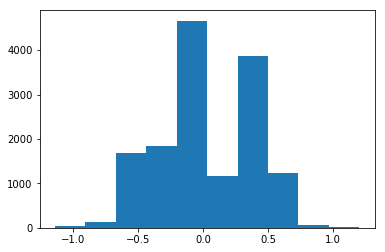

In [17]:
plt.hist(y_train); 
plt.savefig('./images/angles_hist.jpg')

# Generator

In [18]:
def generator(X_images, y_angles, batch_size=BS, training=True):
    
    X_images, y_angles = shuffle(X_images, y_angles)
    while 1:
        for offset in range(0, len(X_images), batch_size):
            X_images_batch = X_images[offset: offset + batch_size]
            y_angles_batch = y_angles[offset: offset + batch_size]
            
            
            batch_images = []
            batch_angles = []
            
            for image, angle in zip(X_images_batch, y_angles_batch):
                image_path = os.path.join(home, data_path, image.strip())
        
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
                #image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV) 
                image = trim_image(image)
                image = resize_image(image)

                if training:
                    ran = random.randint(0, 3)
                else:
                    ran = 99

                if ran == 0:
                    ang = random.randint(-15, 15)
                    image = rotate_image(image, ang)
                    angle += ang 
                if ran == 1:
                    image = bright_image(image) 
                if ran == 2:
                    image = flip_image(image)
                    angle = -1 * angle
                
                batch_images.append(image)
                batch_angles.append(angle)
                
            X = np.array(batch_images)
            y = np.array(batch_angles)
            
            yield shuffle(X, y)

In [19]:
train_generator = generator(X_train, y_train, batch_size=BS, training=True)
valid_generator = generator(X_train, y_train, batch_size=BS, training=False)

# Data Augumentation

In [20]:
def preprocess(image_path, angle):
    #print(image_path)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    image = trim_image(image)
    image = resize_image(image)
    return image, angle

# Visualization

## Get Random Images

In [21]:
def get_random_image(images):
    idx = np.random.randint(0, len(images))
    image = images[idx]
    image = os.path.join(home, data_path, image.strip() )
    image = Image.open(image) 
    return image 

In [22]:
img_cc = get_random_image(images_center_camera)
img_lc = get_random_image(images_left_camera)
img_rc = get_random_image(images_right_camera)

img_ds = get_random_image(d_straight)
img_dl = get_random_image(d_left)
img_dr = get_random_image(d_right)

images_camera = [img_cc, img_lc, img_rc]
images_drives = [img_ds, img_dl, img_dr]

images_drives_flipped = [flip_image(image) for image in images_drives]
images_camera_flipped = [flip_image(image) for image in images_camera]

ang = random.randint(-15, 15)

images_drives_rotated = [rotate_image(image, ang) for image in images_drives]
images_camera_rotated = [rotate_image(image, ang) for image in images_camera]

## Camera, Flipped and Rotated Images

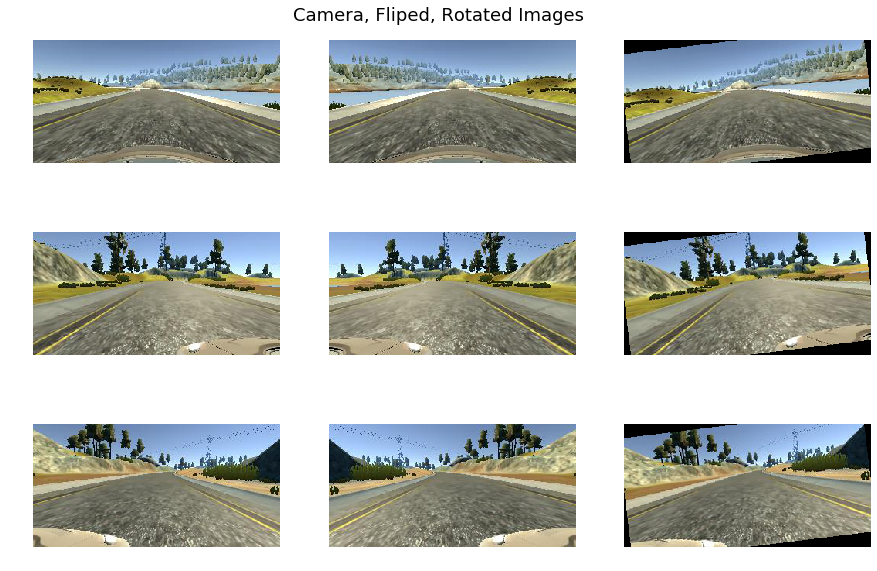

In [23]:
images_c1 = images_camera
images_c2 = images_camera_flipped
images_c3 = images_camera_rotated

fig, axs = plt.subplots(3, 3, figsize=(15,10))

for r, (img_c1, img_c2, img_c3) in enumerate(zip(images_c1, images_c2, images_c3)):
    ax_c1 = axs[r, 0]
    ax_c2 = axs[r, 1]
    ax_c3 = axs[r, 2]
    
    ax_c1.imshow(img_c1)
    ax_c2.imshow(img_c2)
    ax_c3.imshow(img_c3)
    
    ax_c1.axis('off')
    ax_c2.axis('off')
    ax_c3.axis('off')
    
    plt.suptitle('Camera, Fliped, Rotated Images', fontsize=18, y=0.90)
    
plt.savefig('./images/camera.jpg')

## Augmented, Flipped, and Rotated Images 

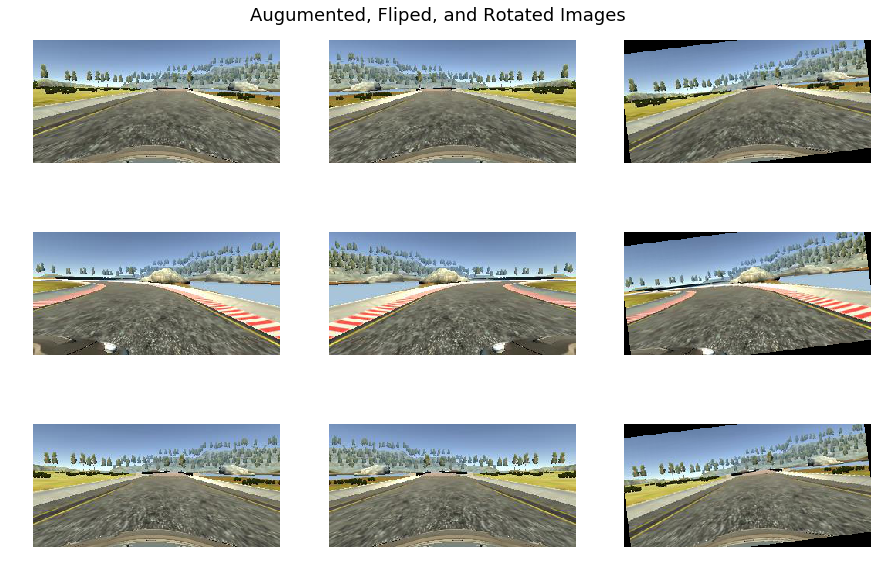

In [24]:
images_c1 = images_drives
images_c2 = images_drives_flipped
images_c3 = images_drives_rotated

ttl = ['Straight Drive [-0.15,0.15]', 'Left Drive (-,-0.15)', 'Right Drive (0.15,-)'] 

fig, axs = plt.subplots(3, 3, figsize=(15,10))

for r, (img_c1, img_c2, img_c3) in enumerate(zip(images_c1, images_c2, images_c3)):
    ax_c1 = axs[r, 0]
    ax_c2 = axs[r, 1]
    ax_c3 = axs[r, 2]
    
    ax_c1.imshow(img_c1)
    ax_c2.imshow(img_c2)
    ax_c3.imshow(img_c3)
    
    ax_c1.axis('off')
    ax_c2.axis('off')
    ax_c3.axis('off')
    
    plt.suptitle('Augumented, Fliped, and Rotated Images', fontsize=18, y=0.90)
    
plt.savefig('./images/augumented.jpg')

# Model

In [25]:
f = lambda x: x / 255 - 0.5 

In [26]:
def nv_model():
    model = Sequential()

    model.add(Lambda(function=f, input_shape=input_shape))

    model.add(Convolution2D(filters=24, kernel_size=(5,5))) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(Convolution2D(filters=36, kernel_size=(5,5)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(Convolution2D(filters=48, kernel_size=(5,5))) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(Convolution2D(filters=64, kernel_size=(3,3))) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(Convolution2D(filters=64, kernel_size=(3,3))) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(1164))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(100))
    model.add(Activation('relu'))

    model.add(Dense(50))
    model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('relu'))

    model.add(Dense(1))
    
    return model 

In [27]:
def nv_model2():
    model = Sequential()

    model.add(Lambda(function=f, input_shape=input_shape))

    model.add(Convolution2D(filters=64, kernel_size=(3,3))) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(Convolution2D(filters=64, kernel_size=(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(Convolution2D(filters=64, kernel_size=(3,3))) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(Convolution2D(filters=68, kernel_size=(3,3))) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(Convolution2D(filters=36, kernel_size=(3,3))) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(1164))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(100))
    model.add(Activation('relu'))

    model.add(Dense(50))
    model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('relu'))

    model.add(Dense(1))
    
    return model 

## Model Summary

In [28]:
model = nv_model2()

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 59, 59, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 58, 58, 64)        0         
__________

# Training

In [29]:
model.compile(optimizer='adam', loss='mse')
#model.compile(optimizer=Adam(1e-4), loss="mse")
    
if retrain:
    model = load_model(model_name)

if n_epochs > 0:
    history_object = model.fit_generator(generator=train_generator,
                                         validation_data=valid_generator,
                                         steps_per_epoch=np.ceil(len(X_train)/BS),
                                         validation_steps=np.ceil(len(X_valid)/BS),
                                         epochs=n_epochs, verbose=1
                                        ) 
    model.save(model_name)

In [30]:
model_name

'/Users/naneja/n-datasets/P-995-CarND-Behavior-Cloning/nvmodel2-RGB.h5'

# Loss 

In [31]:
### print the keys contained in the history object
if n_epochs > 0:
    print(history_object.history.keys())

#print(history_object.history['val_loss'])

### plot the training and validation loss for each epoch
if n_epochs > 0:
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss (except first epoch)')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.savefig('./images/history.jpg')

In [32]:
if n_epochs > 0:
    if retrain:
        loss_train = history_object.history['loss']
        loss_valid = history_object.history['val_loss']
                                        
        df_prev = pd.read_csv(log_name)
        loss_train_prev = df_prev['loss_train'].values.tolist()
        loss_valid_prev = df_prev['loss_valid'].values.tolist()
    
        loss_train_prev.extend(loss_train)
        loss_valid_prev.extend(loss_valid)
                                        
        results = {'loss_train': loss_train_prev, 'loss_valid': loss_valid_prev}
        df = pd.DataFrame(results)
        df.to_csv(log_name, index=False)
    else:
        loss_train = history_object.history['loss']
        loss_valid = history_object.history['val_loss']
        results = {'loss_train': loss_train, 'loss_valid': loss_valid}
        df = pd.DataFrame(results)
        df.to_csv(log_name, index=False)
else:
    df = pd.read_csv(log_name)

print(df.shape)
df.head(5)

(50, 2)


,loss_train,loss_valid
0,15.687618,1.288281
1,1.548361,0.179745
2,0.285399,0.055613
3,0.203373,0.059493
4,0.183987,0.044338


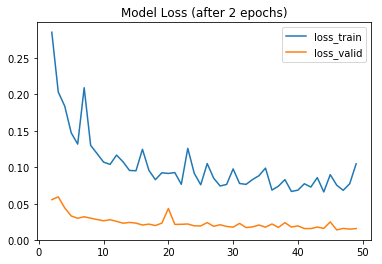

In [33]:
df.iloc[2:,:].plot();
plt.title('Model Loss (after 2 epochs)')
plt.savefig('./images/model_loss.png')

In [34]:
K.clear_session()
del train_generator
del valid_generator
del model
gc.collect()

116163